In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

sys.path.append('../..')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../../sci_style.py')

# Load Data

In [3]:
# # session = 'Mary-Anesthesia-20160912-02'
# # session = 'MrJones-Anesthesia-20160109-01'
# # session = 'Mary-Anesthesia-20160826-02'
# # session = 'MrJones-Anesthesia-20160107-01'
# # session = 'Mary-Anesthesia-20160822-02'
# # session = 'MrJones-Anesthesia-20160113-01'
# # session = 'Mary-Anesthesia-20160809-01'
# # session = 'MrJones-Anesthesia-20160121-01'
# # session = 'Mary-Anesthesia-20160831-02'
# session = 'MrJones-Anesthesia-20160105-01'

# session_list = ['Mary-Anesthesia-20160912-02',
# 'MrJones-Anesthesia-20160109-01',
# 'Mary-Anesthesia-20160826-02',
# 'MrJones-Anesthesia-20160107-01']

# max_freq = 500
# max_unstable_freq = 125
norm = False

results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

session_list = os.listdir(results_dir)

In [4]:
session_rets = {}
for session in tqdm(session_list):
    print("-"*30)
    print(f'SESSION = {session}')
    print("-"*30)
    session_rets[session] = {}
    # ---------------------------------
    # LOAD DATA
    # --------------------------------
    print("loading data...")
    all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

    section_times = dict( 
            wake=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            anesthesia=(eyes_close, session_info['drugEnd'][1]),
            recovery=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
    
    session_rets[session]['electrode_info'] = electrode_info
    session_rets[session]['session_info'] = session_info
    session_rets[session]['eyes_open'] = eyes_open
    session_rets[session]['eyes_close'] = eyes_close
    session_rets[session]['section_times'] = section_times
    session_rets[session]['sections'] = sections
    
    print("data loaded!")
    print("loading results...")
    norm_dir = "NORMED" if norm else "NOT_NORMED"
    total = 0
    for area in os.listdir(os.path.join(results_dir, session, norm_dir)):
        total += len(os.listdir(os.path.join(results_dir, session, norm_dir, area)))
    
    results_dict = {}
    iterator = tqdm(total=total)
    for area in os.listdir(os.path.join(results_dir, session, norm_dir)):
        results_dict[area] = None
        for f in os.listdir(os.path.join(results_dir, session, norm_dir, area)):
            t = float(f.split('_')[0])
            df = pd.DataFrame(pd.read_pickle(os.path.join(results_dir, session, norm_dir, area, f)))
            if len(df) > 0:
                df['area'] = area
                df['start_time'] = t
                df['end_time'] = t + df.window*dt
                df['start_ind'] = int(t/dt)
                df['end_ind'] = int(t/dt) + df.window

                if results_dict[area] is None:
                    results_dict[area] = df
                else:
                    results_dict[area] = pd.concat([results_dict[area], df])
            else:
                print(f"{area}/{f} is empty")
            iterator.update()
        results_dict[area] = results_dict[area].sort_values('start_time')
    
    session_rets[session]['results_dict'] = results_dict
    
    print("results loaded!")
    iterator.close()

  0%|          | 0/21 [00:00<?, ?it/s]

------------------------------
SESSION = MrJones-Anesthesia-20160206-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3555 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160201-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3390 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160109-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/4060 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160121-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3370 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160908-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2210 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160105-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/4155 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160914-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2065 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160107-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/4360 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160831-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2065 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160809-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2360 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160125-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3360 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160912-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2165 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160826-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2250 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160210-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3250 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160822-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2015 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160301-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3300 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160123-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3885 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160113-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3490 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160916-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2155 [00:00<?, ?it/s]

results loaded!


In [5]:
# pd.to_pickle(session_rets, os.path.join("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp", "all_session_rets.pkl"))\
# session_rets = pd.read_pickle(os.path.join("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp", "all_session_rets.pkl"))

# Preprocess Data

In [6]:
leadup_time = 18 # minutes before anesthesia
post_time = 25 # minutes after anesthesia
dt_stab = 0.1
split_by_monkey = True
stability_all = {}
freqs_all = {}
counts = {}
if split_by_monkey:
    monkeys = ['Mary', 'MrJones']
else:
    monkeys = ['Combined']
    
for monkey in monkeys:
    stability_all[monkey] = {}
    freqs_all[monkey] = {}
    counts[monkey] = {}
    
# areas = ['vlPFC', 'FEF', '7b', 'CPB']
areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))

iterator = tqdm(total=total_its)

for monkey in monkeys:
    for area in areas:
        num_params = np.min([len(session_dict['results_dict'][area].stability_params.iloc[0]) for session_dict in session_rets.values()])
        stability_all[monkey][area] = np.zeros((int((leadup_time + 60 + post_time)*60*(1/dt_stab)), num_params), dtype=np.float32)
        freqs_all[monkey][area] = np.zeros((int((leadup_time + 60 + post_time)*60*(1/dt_stab)), num_params), dtype=np.float32)
        counts[monkey][area] = np.zeros(stability_all[monkey][area].shape, dtype=np.int16)
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                    end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                    if start_ind > len(stability_all[monkey][area]):
                        print(start_ind, len(stability_all[monkey][area]))
                        raise ValueError
                    num = np.min([num_params, len(row.stability_params)])
                    stability_all[monkey][area][start_ind:end_ind, :num] += row.stability_params[:num]
                    freqs_all[monkey][area][start_ind:end_ind, :num] += row.stability_freqs[:num]
                    counts[monkey][area][start_ind:end_ind, :num] += 1
                    iterator.update()
iterator.close()

  0%|          | 0/42945 [00:00<?, ?it/s]

In [7]:
palette1 = ['#045275', # dark blue
            '#089099', # teal
            '#7ccba2', # green
            '#fcde9c', # yellow
            '#f0746e', # orange
            '#dc3977', #pink
            '#7c1d6f', #purple
           ]

palette2 = ['#648fff', # blue
            '#785ef0', # midnight
            '#dc267f', # pink
            '#fcde9c', # orange
            '#FE6100', # orange
            '#FFB000', # yellow
           ]

In [8]:
area_colors = {
    'vlPFC': 'C0',
    'FEF': 'skyblue',
    '7b': 'slategray',
    'CPB': 'lightsteelblue', 
    'all': 'purple'
}
# area_colors = {
#     'vlPFC': palette2[0], 
#     'FEF': palette2[2],
#     '7b': palette2[3],
#     'CPB': palette2[4]
# }
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'ALL'
}

# Plot 1

In [46]:
top_percent = 0.1

In [47]:
img_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/images"

In [48]:
# compute means
# compute standard error

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))

iterator = tqdm(total=total_its)

counts_safe_all = {}
mean_stab_all = {}
se_all = {}

for monkey in monkeys:
    counts_safe_all[monkey] = {}
    mean_stab_all[monkey] = {}
    se_all[monkey] = {}
    for area in stability_all[monkey].keys():
        num = int(top_percent*stability_all[monkey][area].shape[1])
        counts_safe = counts[monkey][area][:, :num].sum(axis=1)
        mean_stab_all[monkey][area] = stability_all[monkey][area][:, :num].sum(axis=1)
        mean_stab_all[monkey][area][counts_safe > 0] = mean_stab_all[monkey][area][counts_safe > 0]/counts_safe[counts_safe > 0]
        se_counts = np.zeros(mean_stab_all[monkey][area].shape)
        se_all[monkey][area] = np.zeros(mean_stab_all[monkey][area].shape)
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                    end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                    se_all[monkey][area][start_ind:end_ind] = ((np.expand_dims(row.stability_params[:num], 0) - np.expand_dims(mean_stab_all[monkey][area][start_ind:end_ind], -1))**2).sum(axis=1)
                    se_counts[start_ind:end_ind] += num

                    iterator.update()

        counts_safe_all[monkey][area] = counts_safe
        se_all[monkey][area][counts_safe > 0] = se_all[monkey][area][counts_safe > 0]/se_counts[counts_safe > 0]
        se_all[monkey][area] = np.sqrt(se_all[monkey][area])
        se_all[monkey][area][counts_safe > 0] = se_all[monkey][area][counts_safe > 0]/np.sqrt(se_counts[counts_safe > 0])
iterator.close()

  0%|          | 0/42945 [00:00<?, ?it/s]

In [49]:
eyes_closes = {}
eyes_opens = {}
for monkey in monkeys:
    eyes_closes[monkey] = []
    eyes_opens[monkey] = []
    for session, session_dict in session_rets.items():
        if len(monkey) == 1 or monkey in session:
            
            eyes_closes[monkey].append(session_dict['eyes_close'] - session_dict['session_info']['drugStart'][0])
            eyes_opens[monkey].append(session_dict['eyes_open']  - session_dict['session_info']['drugStart'][0])

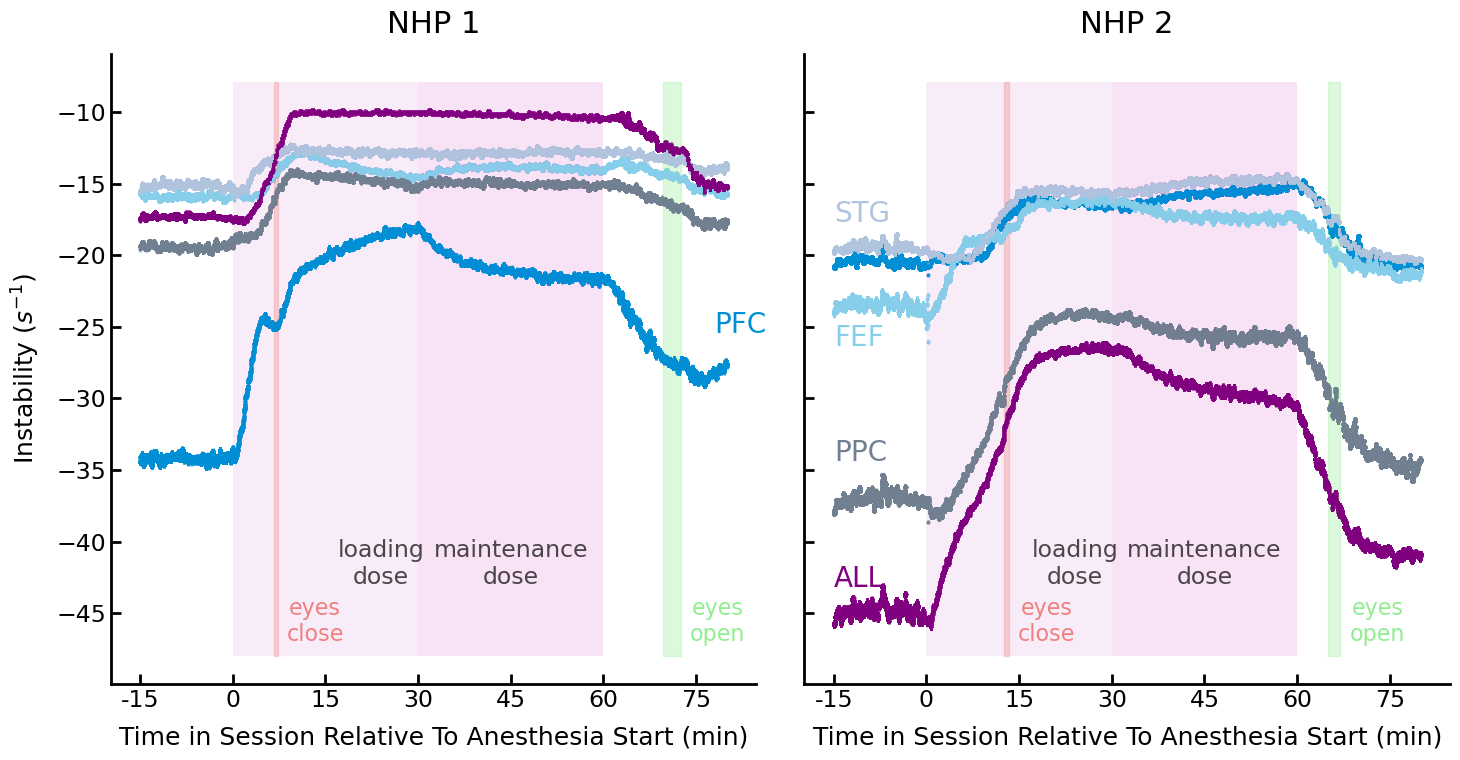

In [50]:
xlabel_fontsize= 18
ylabel_fontsize= 18
tick_fontsize=17
title_fontsize = 22
onplot_fontsize=20

time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 20
s = 4
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

lns = []

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    for area in stability_all[monkey].keys():
        
        ax.scatter(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], label=area_labels[area], color=area_colors[area], s=s)
        ax.errorbar(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], color=area_colors[area], yerr=se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], ls='none', alpha=0.4)
        #         lower_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] - se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
#         upper_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] + se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
#         ax.fill_between(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], lower_bound, upper_bound, alpha=0.4, color=area_colors[area])
        
        if i == 0:
            ln1 = ax.plot([], label=area_labels[area], color=area_colors[area])
            lns += ln1
            
            if area == 'vlPFC':
                ax.text(60 + (plot_end_time - 60)*0.9, mean_stab_all[monkey][area][time_vals >= 60].mean() + 1, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
        if i == 1:
            if area == '7b':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() + 2.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
            if area == 'FEF':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() - 2.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
            if area == 'CPB':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() + 1.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
                
            if area == 'all':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() + 1.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
ylim = ax.get_ylim()
for i in range(2):
    ax = axs[i]
    fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, label='infusion 1', edgecolor='none')
    fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, label='infusion 2', edgecolor='none')
    ax.text(24, ylim[0] + 5, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    ax.text(45, ylim[0] + 5, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    if i == 0:
        lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
        lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        # ax.set_ylabel(f'Mean of Top {top_percent*100:.0f}% Instability ' + r'($s^{-1}$)', fontsize=ylabel_fontsize)
        ax.set_ylabel(f'Instability ' + r'($s^{-1}$)', fontsize=ylabel_fontsize)
    else:
#         ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='y', which='both', left=True, right=False)
    
    xticks = [-15, 0, 15, 30, 45, 60, 75]
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel('Time in Session Relative To Anesthesia Start (min)', fontsize=xlabel_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_title(f'NHP {i + 1}', fontsize=title_fontsize)
    
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
    se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
    ax.text((mean_eyes_close + se_eyes_close)/60 + 6, ylim[0] + 1, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
    se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
    ax.text((mean_eyes_open + se_eyes_open)/60 + 6, ylim[0] + 1, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')
# fig.legend(lns, [ln.get_label() for ln in lns], bbox_to_anchor=(0.9, -0.01), ncol=len(lns), fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "main", "stability-neural-all.pdf"), bbox_inches='tight', transparent=True)
plt.show()

In [51]:
# monkey_colors = ['#003F7D', '#FD7702']
monkey_colors = ['#003F7D', 'deeppink']

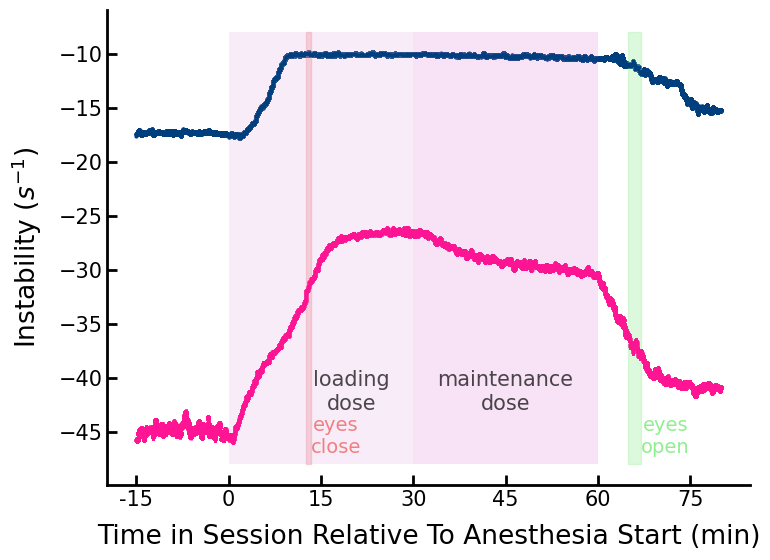

In [17]:
xlabel_fontsize= 19
ylabel_fontsize= 19
tick_fontsize=15
title_fontsize = 22
# legend_fontsize=14
onplot_fontsize=18
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 20
s = 4
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=False)

lns = []

for i, monkey in enumerate(monkeys):
    ax = axs
#     for area in stability_all[monkey].keys():
    for area in ['all']:
        
        ax.scatter(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], label=area_labels[area], color=monkey_colors[i], s=s)
        ax.errorbar(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], color=monkey_colors[i], yerr=se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], ls='none', alpha=0.4)
        #         lower_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] - se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
#         upper_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] + se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
#         ax.fill_between(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], lower_bound, upper_bound, alpha=0.4, color=area_colors[area])
        
        if i == 0:
            ln1 = ax.plot([], label=area_labels[area], color=area_colors[area])
            lns += ln1
            
            if area == 'vlPFC':
                ax.text(60 + (plot_end_time - 60)*0.9, mean_stab_all[monkey][area][time_vals >= 60].mean() + 1, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
        if i == 1:
            if area == '7b':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() + 2.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
            if area == 'FEF':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() - 2.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
            if area == 'CPB':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() + 1.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
                
#             if area == 'all':
#                 ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() + 1.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
ylim = ax.get_ylim()

mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))

#     ax.axvline(mean_eyes_close/60)
ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
ax.text((mean_eyes_close + se_eyes_close)/60 + 4, ylim[0] + 1, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')

mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))

#     ax.axvline(mean_eyes_close/60)
ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
ax.text((mean_eyes_open + se_eyes_open)/60 + 4, ylim[0] + 1, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')

fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, label='infusion 1', edgecolor='none')
fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, label='infusion 2', edgecolor='none')
ax.text(20, ylim[0] + 5, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
ax.text(45, ylim[0] + 5, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_ylabel(f'Instability ' + r'($s^{-1}$)', fontsize=ylabel_fontsize)

xticks = [-15, 0, 15, 30, 45, 60, 75]
ax.set_xticks(xticks, xticks)
ax.set_xlabel('Time in Session Relative To Anesthesia Start (min)', fontsize=xlabel_fontsize)
ax.tick_params(labelsize=tick_fontsize)
#         ax.set_title(f'Monkey {i + 1}', fontsize=title_fontsize)

# fig.legend(lns, [ln.get_label() for ln in lns], bbox_to_anchor=(0.9, -0.01), ncol=len(lns), fontsize=legend_fontsize)
plt.tight_layout()
plt.show()

# Plot 2

In [14]:
top_percent = 0.1

In [15]:
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time

In [16]:
# compute means
# compute standard error

section_info = [('awake', [-15, 0]), ('unconscious', [15, 45]), ('recovery', [75, 85])]

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += len(section_info)*np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)


se_counts_all = {}
mean_stab_all = {}
se_all = {}

for monkey in monkeys:
    mean_stab_all[monkey] = {}
    se_all[monkey] = {}
    se_counts_all[monkey] = {}
    for area in stability_all[monkey].keys():
        num = int(top_percent*stability_all[monkey][area].shape[1])
        counts_safe = counts[monkey][area][:, :num]
        mean_stab_all[monkey][area] = {}
        se_all[monkey][area] = {}
        se_counts_all[monkey][area] = {}
        for section, bounds in section_info:
            mean_stab_all[monkey][area][section] = stability_all[monkey][area][:, :num].copy()
            time_inds = np.logical_and(time_vals >= bounds[0], time_vals <= bounds[1])
            mean_stab_all[monkey][area][section] = mean_stab_all[monkey][area][section][time_inds].sum(axis=0)/counts_safe[time_inds].sum(axis=0)
            
            se_all[monkey][area][section] = np.zeros(mean_stab_all[monkey][area][section].shape)
            se_counts = np.zeros(mean_stab_all[monkey][area][section].shape)
#              = np.zeros(mean_stab_all[monkey][area].shape)
            for session, session_dict in session_rets.items():
                if len(monkeys) == 1 or monkey in session:
                    filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                    for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                        if (row.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0] and (row.start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1]:
    #                         start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
    #                         end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                            se_all[monkey][area][section][:num] += (row.stability_params[:num] - mean_stab_all[monkey][area][section])**2
                            se_counts[:num] += 1

                        iterator.update()
           
            se_all[monkey][area][section] = np.sqrt(se_all[monkey][area][section]/se_counts)/np.sqrt(se_counts)
            se_counts_all[monkey][area][section] = se_counts
            # se_all[monkey][area][section] = np.sqrt(se_all[monkey][area][section]/se_counts)
iterator.close()

  0%|          | 0/128835 [00:00<?, ?it/s]

In [17]:
monkey = 'Mary'
area = 'vlPFC'
sections = ['awake', 'unconscious', 'recovery']

section_colors = {
    'awake': 'limegreen',
    'unconscious': 'plum',
    'recovery': 'orange'
}

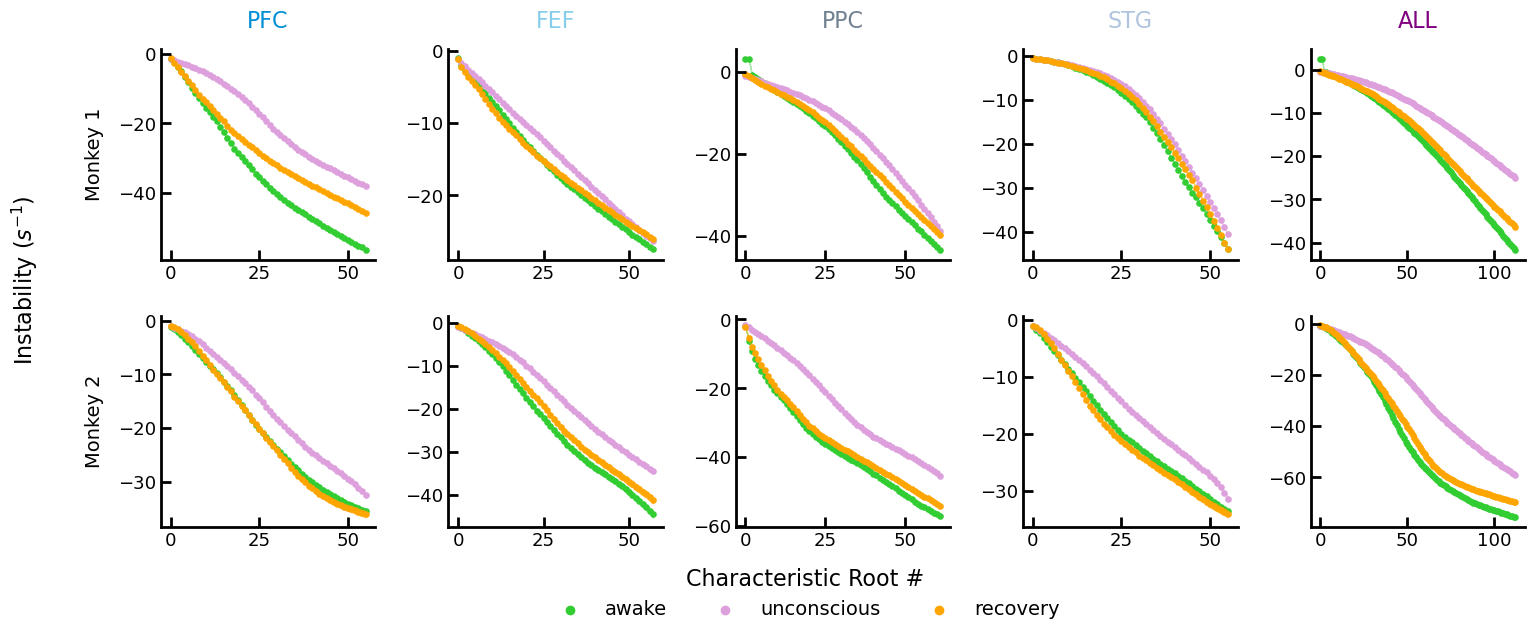

In [18]:
title_fontsize = 16
ylabel_fontsize=16
xlabel_fontsize=16
tick_fontsize=13
legend_fontsize=14
s=14
# fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True)
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharey=False, sharex='col')
lns = []
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        for section in sections:
            mean_vals = mean_stab_all[monkey][area][section]
            ax.scatter(np.arange(len(mean_vals)), mean_vals, c=section_colors[section], label=section, s=s)
            if i == 0 and j == 0:
                scatter = ax.scatter([], [], c=section_colors[section], label=section)
                lns.append(scatter)
            ax.fill_between(np.arange(len(mean_vals)), mean_vals - se_all[monkey][area][section], mean_vals + se_all[monkey][area][section], color=section_colors[section], alpha=0.4)
            
            ax.spines[['right', 'top']].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(labelsize=tick_fontsize)
#             ax.set_xlabel('Characteristic Root #', fontsize=xlabel_fontsize)
            
            if i == 0:
                ax.set_title(area_labels[area], c=area_colors[area], fontsize=title_fontsize)
            if j == 0:
#                 ax.set_ylabel(f'Monkey {i + 1}\nInstability ' + r'($\frac{mV}{s}$)', fontsize=ylabel_fontsize)
                ax.set_ylabel(f'Monkey {i + 1}', fontsize=ylabel_fontsize- 2)
            
#             if j == 0:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.yaxis.set_ticks_position('left')
#                 else:
#                     ax.spines[['right', 'top']].set_visible(False)
#                     ax.xaxis.set_ticks_position('bottom')
#                     ax.yaxis.set_ticks_position('left')
#             else:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
#                 else:
#                     ax.spines[['right', 'top', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=True)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
fig.text(0.5, -0.01, 'Characteristic Root #', ha='center', fontsize=xlabel_fontsize)
fig.text(-0.03, 0.5, 'Instability ' + r'($s^{-1}$)', va='center', rotation='vertical', fontsize=ylabel_fontsize)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3, fontsize=legend_fontsize)
plt.tight_layout()
plt.show()

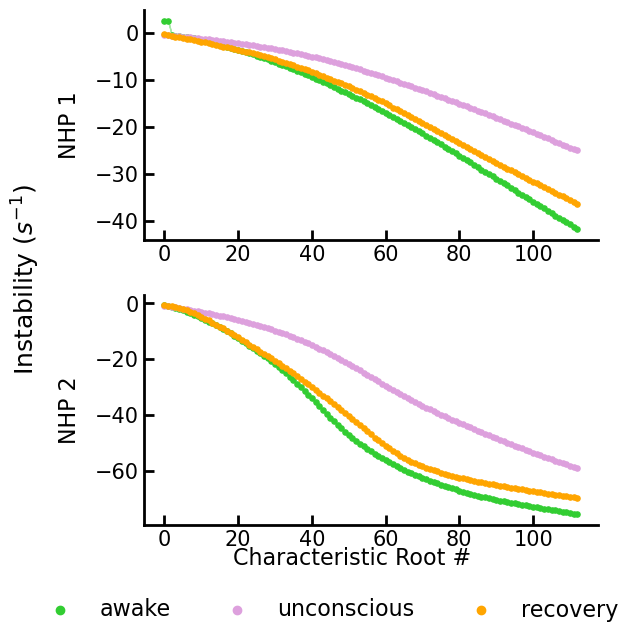

In [19]:
title_fontsize = 18
ylabel_fontsize=18
xlabel_fontsize=18
tick_fontsize=15
legend_fontsize=16
s=14
# fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharey=False, sharex='col')
lns = []
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(['all']):
#         ax = axs[i][j]
        ax = axs[i]
        for section in sections:
            mean_vals = mean_stab_all[monkey][area][section]
            ax.scatter(np.arange(len(mean_vals)), mean_vals, c=section_colors[section], label=section, s=s)
            if i == 0 and j == 0:
                scatter = ax.scatter([], [], c=section_colors[section], label=section)
                lns.append(scatter)
            ax.fill_between(np.arange(len(mean_vals)), mean_vals - se_all[monkey][area][section], mean_vals + se_all[monkey][area][section], color=section_colors[section], alpha=0.4)
            
            ax.spines[['right', 'top']].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(labelsize=tick_fontsize)
#             ax.set_xlabel('Characteristic Root #', fontsize=xlabel_fontsize)
            
            if i == 0:
                pass
#                 ax.set_title(area_labels[area], c=area_colors[area], fontsize=title_fontsize)
            if j == 0:
#                 ax.set_ylabel(f'Monkey {i + 1}\nInstability ' + r'($\frac{mV}{s}$)', fontsize=ylabel_fontsize)
                ax.set_ylabel(f'NHP {i + 1}', fontsize=ylabel_fontsize- 2)
            
#             if j == 0:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.yaxis.set_ticks_position('left')
#                 else:
#                     ax.spines[['right', 'top']].set_visible(False)
#                     ax.xaxis.set_ticks_position('bottom')
#                     ax.yaxis.set_ticks_position('left')
#             else:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
#                 else:
#                     ax.spines[['right', 'top', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=True)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
fig.text(0.54, -0.02, f'Characteristic Root #\n', ha='center', fontsize=xlabel_fontsize - 2)
fig.text(-0.03, 0.5, 'Instability ' + r'($s^{-1}$)', va='center', rotation='vertical', fontsize=ylabel_fontsize)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3, fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "main", "spectrum.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Plot 3

In [20]:
# top_percent = 0.1

In [21]:
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time

In [27]:
# # Find bounds:

# total_its = 0
# for area in areas:
#     for session, session_dict in session_rets.items():
#         total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].start_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
# min_val = {}  
# max_val = {}

# iterator = tqdm(total=total_its)
# for monkey in monkeys:
#     min_val[monkey] = {}
#     max_val[monkey] = {}
#     for area in stability_all[monkey].keys():
#         min_val[monkey][area] = np.Inf
#         max_val[monkey][area] = -np.Inf
#         for session, session_dict in session_rets.items():
#             if len(monkeys) == 1 or monkey in session:
#                 filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].start_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
#                 for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
#                     min_val_row = row.stability_params[int(top_percent*len(row.stability_params))]
#                     max_val_row = row.stability_params[0]
                    
#                     if min_val_row < min_val[monkey][area]:
#                         min_val[monkey][area] = min_val_row

#                     if max_val_row > max_val[monkey][area]:
#                         max_val[monkey][area] = max_val_row

#                     iterator.update()
# iterator.close()


In [28]:
# compute means
# compute standard error
total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)

density = True
log_density = False
bin_nums = 20

criticality_prob_dists = {}
counts_dist = {}
bins_all = {}
# mean_stab_all = {}
# se_all = {}

for monkey in monkeys:
    criticality_prob_dists[monkey] = {}
    counts_dist[monkey] = {}
    bins_all[monkey] = {}
#     mean_stab_all[monkey] = {}
#     se_all[monkey] = {}
    for area in stability_all[monkey].keys():
        criticality_prob_dists[monkey][area] = np.zeros((len(time_vals), bin_nums))
        counts_dist[monkey][area] = np.zeros(criticality_prob_dists[monkey][area].shape)
#         emin = min_val[monkey][area]
#         emax = max_val[monkey][area]
        emax = np.max([mean_stab_all[monkey][area][section][0] + 0.5*np.sqrt(se_counts_all[monkey][area][section])*se_all[monkey][area][section][0] for section in sections])
        emin = np.min([mean_stab_all[monkey][area][section][-1] - 0.5*np.sqrt(se_counts_all[monkey][area][section])*se_all[monkey][area][section][-1] for section in sections])
        bins = [(emax - emin)*i/bin_nums + emin for i in range(bin_nums + 1 )]
        bins_all[monkey][area] = bins
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                    end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                    hist_vals  = np.histogram(row.stability_params[:int(top_percent*len(row.stability_params))], bins=bins, density=density)[0]
                    if log_density:
                        hist_vals = [np.log(d) for d in np.histogram(stab_params.iloc[t], bins=bins, density=density)[0] if d > 0]
                    criticality_prob_dists[monkey][area][start_ind:end_ind] += hist_vals
                    counts_dist[monkey][area][start_ind:end_ind] += 1
                    iterator.update()
        
        counts_safe = counts_dist[monkey][area].copy()
        criticality_prob_dists[monkey][area][counts_safe > 0] /= counts_safe[counts_safe > 0]

iterator.close()

  0%|          | 0/42945 [00:00<?, ?it/s]

In [29]:
eyes_closes = {}
eyes_opens = {}
for monkey in monkeys:
    eyes_closes[monkey] = []
    eyes_opens[monkey] = []
    for session, session_dict in session_rets.items():
        if len(monkey) == 1 or monkey in session:
            
            eyes_closes[monkey].append(session_dict['eyes_close'] - session_dict['session_info']['drugStart'][0])
            eyes_opens[monkey].append(session_dict['eyes_open']  - session_dict['session_info']['drugStart'][0])

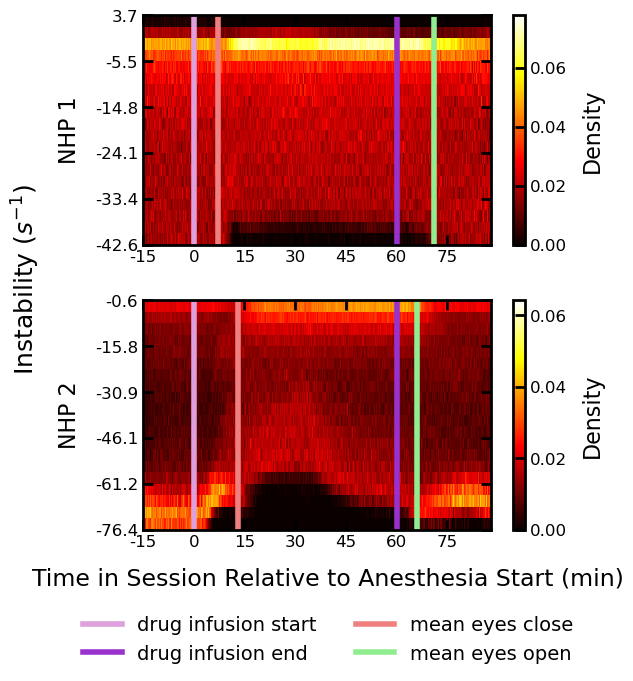

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
ytick_fontsize=12
xtick_fontsize=12
title_fontsize = 18
ylabel_fontsize=18
xlabel_fontsize=17
cbarlabel_fontsize=16
cbarticks_fontsize=12
legend_fontsize=14

linewidth = 4

for i, monkey in enumerate(monkeys):
    
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
#     se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
#     se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     for j, area in enumerate(areas):
    for j, area in enumerate(['all']):
        ax = axs[i]
        im = ax.pcolormesh(criticality_prob_dists[monkey][area].T, cmap='hot')
        ax.set_yticks(np.arange(0, bin_nums + 1, 4))
        ax.set_yticklabels([f"{b:.1f}" for b in np.array(bins_all[monkey][area])[np.arange(0, bin_nums + 1, 4)]], fontsize=ytick_fontsize)
        x_step = 15 # mins
        xtick_locs = np.arange(0, int(criticality_prob_dists[monkey][area].shape[0]), x_step*60/dt_stab)
        ax.set_xticks(xtick_locs)
        ax.set_xticklabels([int(loc*dt_stab/60) - 15 for loc in xtick_locs], fontsize=xtick_fontsize)
        
        if j == 0:
            ax.set_ylabel(f'NHP {i + 1}', fontsize=ylabel_fontsize - 2)
#         if i == 0:
#             ax.set_title(area_labels[area], c=area_colors[area], fontsize=title_fontsize)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(label='Density', fontsize=cbarlabel_fontsize)
        cbar.ax.tick_params(labelsize=cbarticks_fontsize)
#         cbar.set_label('Stability Density' if density else '# Modes', fontsize=cbarlabel_fontsize)

        lns = []
        lns.append(ax.axvline((0 + 15)*60/dt_stab, color='plum', label=f"drug infusion start", linewidth=linewidth))
        lns.append(ax.axvline((60 + 15)*60/dt_stab, color='darkorchid', label='drug infusion end', linewidth=linewidth))
        lns.append(ax.axvline((mean_eyes_close + 15*60)/dt_stab, color='lightcoral', label=f"mean eyes close", linewidth=linewidth))
        lns.append(ax.axvline((mean_eyes_open + 15*60)/dt_stab, color='lightgreen', label=f"mean eyes open", linewidth=linewidth))

fig.text(0.5, -0.01, 'Time in Session Relative to Anesthesia Start (min)', ha='center', fontsize=xlabel_fontsize)
fig.text(-0.03, 0.5, 'Instability ' + r'($s^{-1}$)', va='center', rotation='vertical', fontsize=ylabel_fontsize)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.1), loc='center', ncol=2, fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "main", "densities.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Plot 4

In [12]:
section_info = [('wake', [-15, 0]), ('anesthesia', [15, 45])]
# top_percents = [0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 0.45, 0.5]
d_percent = 0.01
top_percents = np.arange(d_percent, 0.5 + d_percent/2, d_percent)

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += len(top_percents)*len(section_info)*np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)

# all_vals = {}
mannwhitney_rets = {}

for monkey in monkeys:
    mannwhitney_rets[monkey] = {}
    for area in stability_all[monkey].keys():
        mannwhitney_rets[monkey][area] = {}
        for top_percent in top_percents:
            section_vals = {}
            for section, bounds in section_info:
                section_vals[section] = []
                for session, session_dict in session_rets.items():
                    if len(monkeys) == 1 or monkey in session:
                        filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                        for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                            if (row.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0] and (row.start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1]:
                                section_vals[section].extend(row.stability_params[:int(top_percent*len(row.stability_params))])
                            iterator.update()
            
            stat, p = scipy.stats.mannwhitneyu(section_vals['wake'], section_vals['anesthesia'], alternative='less')
            mannwhitney_rets[monkey][area][top_percent] = {'stat': stat, 'p': p}
iterator.close()

  0%|          | 0/4294500 [00:00<?, ?it/s]

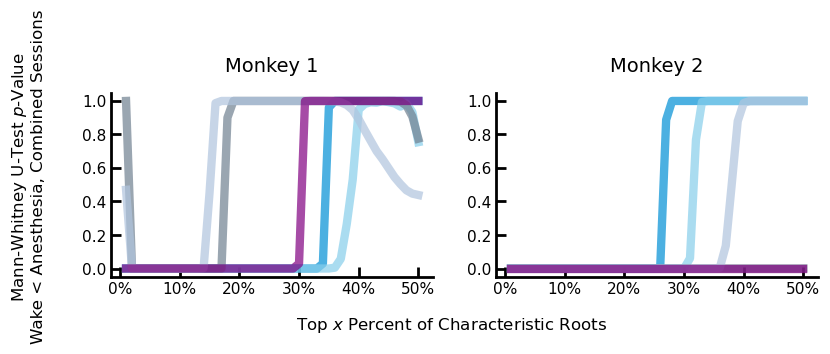

In [13]:
tick_fontsize=11
xlabel_fontsize=12
ylabel_fontsize=12
title_fontsize = 14
linewidth=6
# fig, axs = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True)
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
s = 7

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    for j, area in enumerate(areas):
#         ax = axs[i][j]
#         ax.bar(list(mannwhitney_rets[monkey][area].keys()), [value['p'] for value in mannwhitney_rets[monkey][area].values()], alpha=0.7, width=top_percents[1] - top_percents[0])
#         ax.scatter(list(mannwhitney_rets[monkey][area].keys()), [value['p'] for value in mannwhitney_rets[monkey][area].values()], alpha=0.7, s=s, color=area_colors[area])
        ax.plot(np.array(list(mannwhitney_rets[monkey][area].keys()))*100, [value['p'] for value in mannwhitney_rets[monkey][area].values()], alpha=0.7, color=area_colors[area], linewidth=linewidth)
        ax.set_xticks(np.arange(0, 51, 10))
        ax.set_xticklabels([f"{i}%" for i in np.arange(0, 51, 10)])
        ax.set_title(f"Monkey {i + 1}", fontsize=title_fontsize)
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(labelsize=tick_fontsize)
        
fig.text(0.5, -0.01, 'Top $x$ Percent of Characteristic Roots', ha='center', fontsize=xlabel_fontsize)
fig.text(-0.03, 0.5, 'Mann-Whitney U-Test $p$-Value\nWake < Anesthesia, Combined Sessions', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)
plt.tight_layout()
plt.show()

# Plot 5

In [14]:
section_info = [('wake', [-15, 0]), ('anesthesia', [15, 45])]
# top_percents = [0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 0.45, 0.5]
d_percent = 0.01
top_percents = np.arange(d_percent, 0.5 + d_percent/2, d_percent)

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += len(top_percents)*len(section_info)*np.sum(np.logical_and(session_dict['results_dict'][area].end_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].start_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)

# all_vals = {}
mannwhitney_rets_session = {}

for monkey in monkeys:
    mannwhitney_rets_session[monkey] = {}
    for area in stability_all[monkey].keys():
        mannwhitney_rets_session[monkey][area] = {}
        
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                mannwhitney_rets_session[monkey][area][session] = {}
                for top_percent in top_percents:
                    section_vals = {}
                    for section, bounds in section_info:
                        section_vals[section] = []
                        filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].start_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                        for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                            if (row.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0] and (row.end_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1]:
                                section_vals[section].extend(row.stability_params[:int(top_percent*len(row.stability_params))])
                                iterator.update()
            
                    stat, p = scipy.stats.mannwhitneyu(section_vals['wake'], section_vals['anesthesia'], alternative='less')
                    mannwhitney_rets_session[monkey][area][session][top_percent] = {'stat': stat, 'p': p}
iterator.close()

  0%|          | 0/4314000 [00:00<?, ?it/s]

In [15]:
percent_sessions = {}
for monkey in monkeys:
    percent_sessions[monkey] = {}
    for area in areas:
        percent_sessions[monkey][area] = {}
        for top_percent in top_percents:
            vals = [mannwhitney_rets_session[monkey][area][key][top_percent]['p'] <= 0.05 for key in mannwhitney_rets_session[monkey][area].keys()]
            percent_sessions[monkey][area][top_percent] = np.sum(vals)/len(mannwhitney_rets_session[monkey][area].keys())

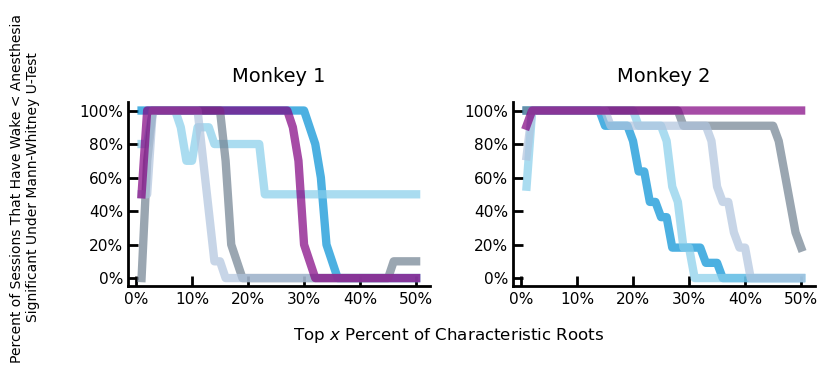

In [16]:
tick_fontsize=11
xlabel_fontsize=12
ylabel_fontsize=10
title_fontsize = 14
linewidth=6
# fig, axs = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True)
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
s = 7

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    for j, area in enumerate(areas):
#         ax = axs[i][j]
#         ax.bar(list(mannwhitney_rets[monkey][area].keys()), [value['p'] for value in mannwhitney_rets[monkey][area].values()], alpha=0.7, width=top_percents[1] - top_percents[0])
#         ax.scatter(list(mannwhitney_rets[monkey][area].keys()), [value['p'] for value in mannwhitney_rets[monkey][area].values()], alpha=0.7, s=s, color=area_colors[area])
        ax.plot(np.array(list(percent_sessions[monkey][area].keys()))*100, [value*100 for value in percent_sessions[monkey][area].values()], alpha=0.7, color=area_colors[area], linewidth=linewidth)
        ax.set_xticks(np.arange(0, 51, 10))
        ax.set_xticklabels([f"{i}%" for i in np.arange(0, 51, 10)])
        ax.set_title(f"Monkey {i + 1}", fontsize=title_fontsize)
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(labelsize=tick_fontsize)
        
        ax.set_yticks(np.arange(0, 101, 20))
        ax.set_yticklabels([f"{int(tick):d}%" for tick in np.arange(0, 101, 20)])
        
fig.text(0.5, -0.01, 'Top $x$ Percent of Characteristic Roots', ha='center', fontsize=xlabel_fontsize)
fig.text(-0.03, 0.5, 'Percent of Sessions That Have Wake < Anesthesia \nSignificant Under Mann-Whitney U-Test', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)
plt.tight_layout()
plt.show()

# Plot 6

In [40]:
top_percent = 0.1

In [41]:
section_info = [('wake', [-15, 0]), ('anesthesia', [15, 45])]
leadup_time = 18 # minutes before anesthesia
post_time = 25 # minutes after anesthesia

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)

changes_all = {}
counts_changes = {}

for monkey in monkeys:
    changes_all[monkey] = {}
    counts_changes[monkey] = {}
    for area in stability_all[monkey].keys():
        changes_all[monkey][area] = np.zeros(int((leadup_time + 60 + post_time)*60*(1/dt_stab)), dtype=np.float32)
        counts_changes[monkey][area] = np.zeros(changes_all[monkey][area].shape, dtype=np.int32)
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                wake_rows = session_dict['results_dict'][area][np.logical_and(filter_inds, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugStart'][0])]
#                 length = np.min([int(top_percent*len(row.stability_params)) for _, row in wake_rows.iterrows()])
#                 wakeful_mean = -1/wake_rows.stability_params.apply(lambda x: x[:length]).mean()
                wakeful_mean = np.exp(np.log(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]).to_numpy())).mean())
                if wakeful_mean < 0:
                    raise ValueError
                for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                    end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
#                     row_mean = -1/(row.stability_params[:int(top_percent*len(row.stability_params))].mean())
#                     row_vals = -1/row.stability_params[:len(wakeful_mean)]
#                     changes_all[monkey][area][start_ind:end_ind] += np.sum(row_vals/wakeful_mean)
#                     row_mean = np.exp(np.log(-1/row.stability_params[row.stability_params <= 0][:int(top_percent*len(row.stability_params))]).mean())
#                     changes_all[monkey][area][start_ind:end_ind] += row_mean/wakeful_mean
#                     above_0 = row.stability_params > 0
#                     if area == 'all' and np.sum(above_0) > 0:
# #                         print(row.stability_params[above_0])
# #                         print(row.stability_freqs[above_0])
#                         if np.sum(np.abs(row.stability_freqs[above_0]) < 10) > 0:
#                             print((row.start_time - session_dict['session_info']['drugStart'][0])/60)
#                             print(row.stability_params[above_0][np.abs(row.stability_freqs[above_0]) < 10])
#                             print(row.stability_freqs[above_0][np.abs(row.stability_freqs[above_0]) < 10])
    
                    row_vals = -1/row.stability_params[row.stability_params <= 0][:int(top_percent*len(row.stability_params))]
                    changes_all[monkey][area][start_ind:end_ind] += np.sum(np.log(row_vals/wakeful_mean))
#                     counts_changes[monkey][area][start_ind:end_ind] += 1
                    counts_changes[monkey][area][start_ind:end_ind] += len(row_vals)
#                     if changes_all[monkey][area][start_ind] > 10:
#                         print(changes_all[monkey][area].shape)
#                         print(changes_all[monkey][area][start_ind]/counts_changes[monkey][area][start_ind])
                    iterator.update()
        
        counts_safe = np.copy(counts_changes[monkey][area])
        changes_all[monkey][area][counts_safe > 0] = np.exp(changes_all[monkey][area][counts_safe > 0]/counts_safe[counts_safe > 0])
iterator.close()

  0%|          | 0/42945 [00:00<?, ?it/s]

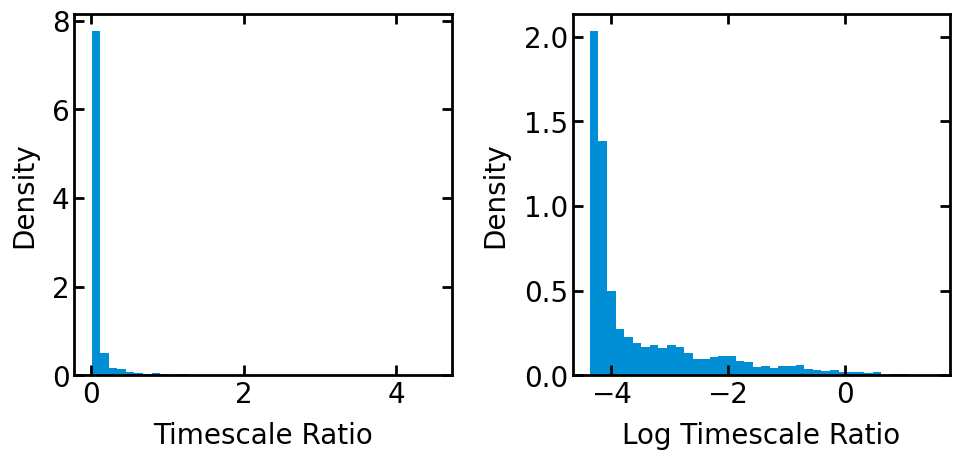

In [42]:
plt.subplot(1, 2, 1)
plt.hist(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))])), bins=40, density=True)
plt.xlabel('Timescale Ratio')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(np.log(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]))), bins=40, density=True)
plt.xlabel('Log Timescale Ratio')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [43]:
section_info = [('wake', [-15, 0]), ('anesthesia', [15, 45])]

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)

se_changes_all = {}
counts_changes_se = {}

for monkey in monkeys:
    se_changes_all[monkey] = {}
    counts_changes_se[monkey] = {}
    for area in stability_all[monkey].keys():
        se_changes_all[monkey][area] = np.zeros(int((leadup_time + 60 + post_time)*60*(1/dt_stab)), dtype=np.float32)
        counts_changes_se[monkey][area] = np.zeros(changes_all[monkey][area].shape, dtype=np.int16)
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                wake_rows = session_dict['results_dict'][area][np.logical_and(filter_inds, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugStart'][0])]
#                 length = np.min([int(top_percent*len(row.stability_params)) for _, row in wake_rows.iterrows()])
#                 wakeful_mean = -1/wake_rows.stability_params.apply(lambda x: x[:length]).mean()
#                 wakeful_mean = (-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy())).mean()
                wakeful_mean = np.exp(np.log(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]))).mean())
#                 wakeful_mean = (-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]).to_numpy())).mean()
                for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                    end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
#                     row_mean = -1/(row.stability_params[:int(top_percent*len(row.stability_params))]).mean()
#                     row_mean = np.exp(np.log(-1/row.stability_params[row.stability_params <= 0][:int(top_percent*len(row.stability_params))]).mean())
                    row_vals = -1/row.stability_params[row.stability_params <= 0][:int(top_percent*len(row.stability_params))]
#                     counts_changes[monkey][area][start_ind:end_ind] += 1
                    se_changes_all[monkey][area][start_ind:end_ind] += ((np.expand_dims(np.log(row_vals/wakeful_mean), -1) - np.expand_dims(np.log(changes_all[monkey][area][start_ind:end_ind]), 0))**2).sum(axis=0)
                    counts_changes_se[monkey][area][start_ind:end_ind] += len(row_vals)
                    iterator.update()
        
        counts_safe = np.copy(counts_changes_se[monkey][area])
        se_changes_all[monkey][area][counts_safe > 0] = se_changes_all[monkey][area][counts_safe > 0]/counts_safe[counts_safe > 0]
        se_changes_all[monkey][area] = np.sqrt(se_changes_all[monkey][area])
        se_changes_all[monkey][area][counts_safe > 0] /= np.sqrt(counts_safe[counts_safe > 0])
        se_changes_all[monkey][area][counts_safe > 0] = np.exp(se_changes_all[monkey][area][counts_safe > 0])
iterator.close()

  0%|          | 0/42945 [00:00<?, ?it/s]

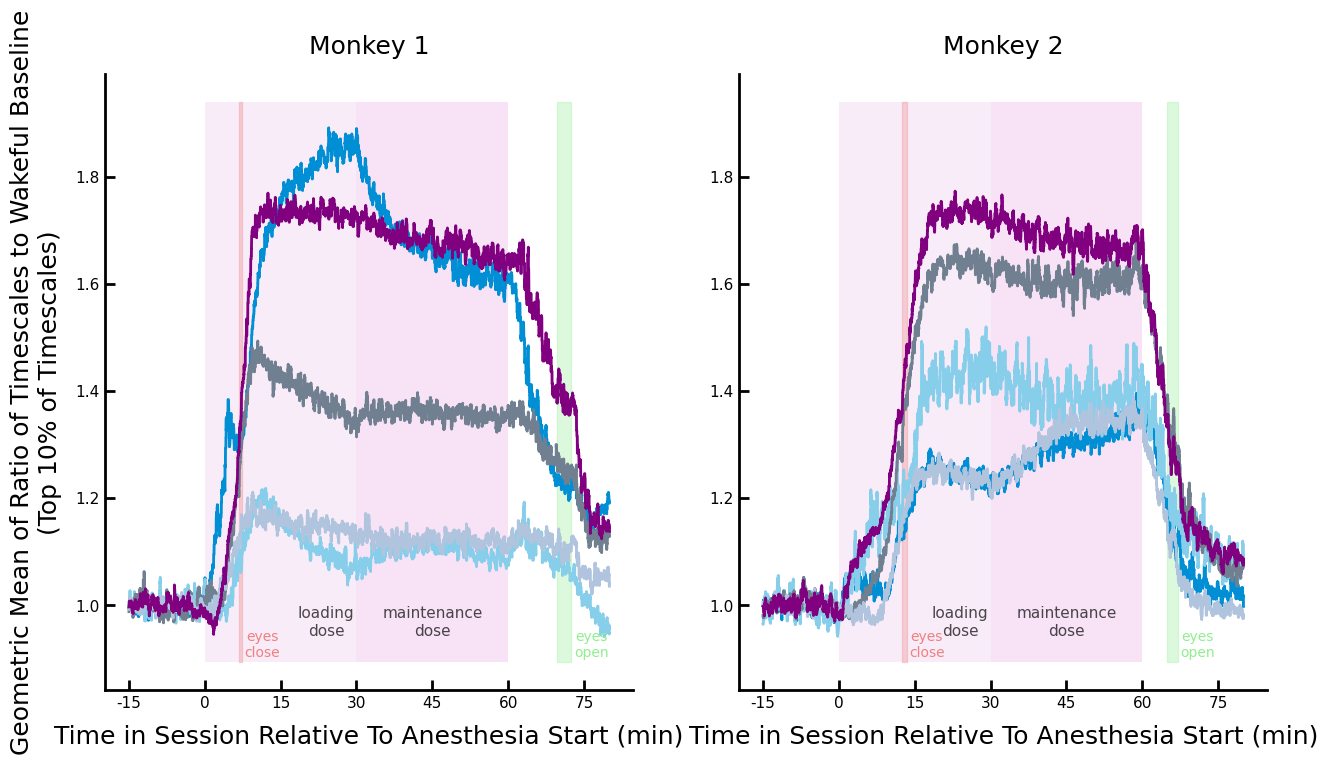

In [44]:
tick_fontsize=11
onplot_fontsize = 14
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 20
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    for j, area in enumerate(areas):
        ax.plot(time_vals[time_inds], changes_all[monkey][area][time_inds], label=area_labels[area], color=area_colors[area])
        
#         lower_bound = changes_all[monkey][area] - se_changes_all[monkey][area]
#         upper_bound = changes_all[monkey][area] + se_changes_all[monkey][area]
        lower_bound = changes_all[monkey][area]
        upper_bound = changes_all[monkey][area]
        lower_bound[counts_changes_se[monkey][area] > 0] = np.exp(np.log(changes_all[monkey][area][counts_changes_se[monkey][area] > 0]) - np.log(se_changes_all[monkey][area][counts_changes_se[monkey][area] > 0]))
        upper_bound[counts_changes_se[monkey][area] > 0] = np.exp(np.log(changes_all[monkey][area][counts_changes_se[monkey][area] > 0]) + np.log(se_changes_all[monkey][area][counts_changes_se[monkey][area] > 0]))
        ax.fill_between(time_vals[time_inds], lower_bound[time_inds], upper_bound[time_inds], alpha=0.4, color=area_colors[area])
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(labelsize=tick_fontsize)
ylim = ax.get_ylim()
for i in range(2):
    ax = axs[i]
    fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, label='infusion 1', edgecolor='none')
    fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, label='infusion 2', edgecolor='none')
    ax.text(24, ylim[0] + 0.05, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    ax.text(45, ylim[0] + 0.05, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    if i == 0:
        lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
        lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_ylabel(f'Geometric Mean of Ratio of Timescales to Wakeful Baseline\n(Top 10% of Timescales)', fontsize=ylabel_fontsize)
    else:
#         ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='y', which='both', left=True, right=False)
    
    xticks = [-15, 0, 15, 30, 45, 60, 75]
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel('Time in Session Relative To Anesthesia Start (min)', fontsize=xlabel_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_title(f'Monkey {i + 1}', fontsize=title_fontsize)
    
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
    se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
    ax.text((mean_eyes_close + se_eyes_close)/60 + 4, ylim[0] + 0.01, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
    se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
    ax.text((mean_eyes_open + se_eyes_open)/60 + 4, ylim[0] + 0.01, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')

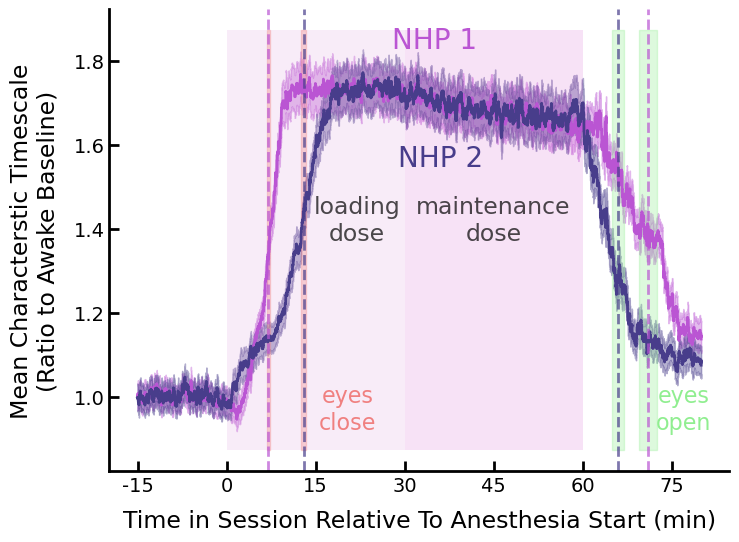

In [45]:
tick_fontsize=14
onplot_fontsize = 20
ylabel_fontsize = 17
xlabel_fontsize = 17
legend_fontsize = 16
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 20
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=True)

monkey_colors = ['mediumorchid', 'darkslateblue']
for i, monkey in enumerate(monkeys):
    ax = axs
    for j, area in enumerate(['all']):
        color = monkey_colors[i]
        ax.plot(time_vals[time_inds], changes_all[monkey][area][time_inds], color=color, label=f'monkey {i + 1} all areas')
        
#         lower_bound = changes_all[monkey][area] - se_changes_all[monkey][area]
#         upper_bound = changes_all[monkey][area] + se_changes_all[monkey][area]
        lower_bound = changes_all[monkey][area].copy()
        upper_bound = changes_all[monkey][area].copy()
        lower_bound[counts_changes_se[monkey][area] > 0] = np.exp(np.log(changes_all[monkey][area][counts_changes_se[monkey][area] > 0]) - np.log(se_changes_all[monkey][area][counts_changes_se[monkey][area] > 0]))
        upper_bound[counts_changes_se[monkey][area] > 0] = np.exp(np.log(changes_all[monkey][area][counts_changes_se[monkey][area] > 0]) + np.log(se_changes_all[monkey][area][counts_changes_se[monkey][area] > 0]))
        ax.fill_between(time_vals[time_inds], lower_bound[time_inds], upper_bound[time_inds], alpha=0.4, color=monkey_colors[i])
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(labelsize=tick_fontsize)
ylim = ax.get_ylim()
fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, edgecolor='none')
fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, edgecolor='none')
ax.text(22, ylim[0] + (ylim[1] - ylim[0])*0.5, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
ax.text(45, ylim[0] + (ylim[1] - ylim[0])*0.5, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
if i == 0:
    lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
    lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
if i == 0:
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
else:
#         ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='y', which='both', left=True, right=False)
    
ax.set_ylabel(f'Mean Characterstic Timescale\n(Ratio to Awake Baseline)', fontsize=ylabel_fontsize)

xticks = [-15, 0, 15, 30, 45, 60, 75]
ax.set_xticks(xticks, xticks)
ax.set_xlabel('Time in Session Relative To Anesthesia Start (min)', fontsize=xlabel_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# ax.set_title(f'Monkey {i + 1}', fontsize=title_fontsize)
    
for i in range(2):
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
    se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
    if i == 1:
        xshift = 7
    else:
        xshift = -4
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
    ax.axvline(mean_eyes_close/60, linestyle='--', color=monkey_colors[i], alpha=0.7, linewidth=2)
    if i == 1:
        ax.text((mean_eyes_close + se_eyes_close)/60 + xshift, ylim[0] + (ylim[1] - ylim[0])*0.05, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
    se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)

    if i == 1:
        xshift = 10
    else:
        xshift = -4
    
    ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
    ax.axvline(mean_eyes_open/60, linestyle='--', color=monkey_colors[i], alpha=0.7, linewidth=2)
    if i == 1:
        ax.text((mean_eyes_open + se_eyes_open)/60 + xshift, ylim[0] + (ylim[1] - ylim[0])*0.05, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')
        
# ax.legend(fontsize=legend_fontsize, loc='upper left', bbox_to_anchor=(0.95, 1))
ax.text(35, 1.83, "NHP 1", color=monkey_colors[0], ha='center', fontsize=onplot_fontsize)
ax.text(36, 1.55, "NHP 2", color=monkey_colors[1], ha='center', fontsize=onplot_fontsize)
plt.savefig(os.path.join(img_save_dir, "main", "stability-timescales.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Plot 7

In [45]:
top_percent = 0.1

In [46]:
# compute means
# compute standard error

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))

iterator = tqdm(total=total_its)

counts_safe_all = {}
mean_stab_all = {}
se_all = {}

for monkey in monkeys:
    counts_safe_all[monkey] = {}
    mean_stab_all[monkey] = {}
    se_all[monkey] = {}
    for area in stability_all[monkey].keys():
        num = int(top_percent*stability_all[monkey][area].shape[1])
        counts_safe = counts[monkey][area][:, :num].sum(axis=1)
        mean_stab_all[monkey][area] = stability_all[monkey][area][:, :num].sum(axis=1)
        mean_stab_all[monkey][area][counts_safe > 0] = mean_stab_all[monkey][area][counts_safe > 0]/counts_safe[counts_safe > 0]
        
#         mean_stab_all[monkey][area] = np.zeros(stability_all[monkey][area][:, :num].shape[0])
#         mean_stab_all[monkey][area][counts_safe > 0] = (-1/stability_all[monkey][area][counts_safe > 0][:, :num]).sum(axis=1)
#         mean_stab_all[monkey][area][counts_safe > 0] = mean_stab_all[monkey][area][counts_safe > 0]/counts_safe[counts_safe > 0]
        #         mean_stab_all[monkey][area][counts_safe > 0] = 1/mean_stab_all[monkey][area][counts_safe > 0]
        se_counts = np.zeros(mean_stab_all[monkey][area].shape)
        se_all[monkey][area] = np.zeros(mean_stab_all[monkey][area].shape)
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                    end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                    se_all[monkey][area][start_ind:end_ind] = ((np.expand_dims(row.stability_params[:num], 0) - np.expand_dims(mean_stab_all[monkey][area][start_ind:end_ind], -1))**2).sum(axis=1)
                    se_counts[start_ind:end_ind] += num

                    iterator.update()

        counts_safe_all[monkey][area] = counts_safe
        se_all[monkey][area][counts_safe > 0] = se_all[monkey][area][counts_safe > 0]/se_counts[counts_safe > 0]
        se_all[monkey][area] = np.sqrt(se_all[monkey][area])
        se_all[monkey][area][counts_safe > 0] = se_all[monkey][area][counts_safe > 0]/np.sqrt(se_counts[counts_safe > 0])
iterator.close()

  0%|          | 0/42945 [00:00<?, ?it/s]

In [47]:
eyes_closes = {}
eyes_opens = {}
for monkey in monkeys:
    eyes_closes[monkey] = []
    eyes_opens[monkey] = []
    for session, session_dict in session_rets.items():
        if len(monkey) == 1 or monkey in session:
            
            eyes_closes[monkey].append(session_dict['eyes_close'] - session_dict['session_info']['drugStart'][0])
            eyes_opens[monkey].append(session_dict['eyes_open']  - session_dict['session_info']['drugStart'][0])

In [48]:
section_info = [('wake', [-15, 0]), ('anesthesia', [15, 45])]
leadup_time = 18 # minutes before anesthesia
post_time = 25 # minutes after anesthesia

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)

changes_all = {}
counts_changes = {}

for monkey in monkeys:
    changes_all[monkey] = {}
    counts_changes[monkey] = {}
    for area in stability_all[monkey].keys():
        changes_all[monkey][area] = np.zeros(int((leadup_time + 60 + post_time)*60*(1/dt_stab)), dtype=np.float32)
        counts_changes[monkey][area] = np.zeros(changes_all[monkey][area].shape, dtype=np.int32)
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                wake_rows = session_dict['results_dict'][area][np.logical_and(filter_inds, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugStart'][0])]
#                 length = np.min([int(top_percent*len(row.stability_params)) for _, row in wake_rows.iterrows()])
#                 wakeful_mean = -1/wake_rows.stability_params.apply(lambda x: x[:length]).mean()
                wakeful_mean = np.exp(np.log(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]).to_numpy())).mean())
# #                 wakeful_mean = (-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]).to_numpy())).mean()
#                 wake_vals = (-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]).to_numpy()))
                
                if wakeful_mean < 0:
                    raise ValueError
                for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                    end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
#                     row_mean = -1/(row.stability_params[:int(top_percent*len(row.stability_params))].mean())
#                     row_vals = -1/row.stability_params[:len(wakeful_mean)]
#                     changes_all[monkey][area][start_ind:end_ind] += np.sum(row_vals/wakeful_mean)
#                     row_mean = np.exp(np.log(-1/row.stability_params[row.stability_params <= 0][:int(top_percent*len(row.stability_params))]).mean())
#                     changes_all[monkey][area][start_ind:end_ind] += row_mean/wakeful_mean
                    row_vals = -1/row.stability_params[row.stability_params <= 0][:int(top_percent*len(row.stability_params))]
                    changes_all[monkey][area][start_ind:end_ind] += np.sum(np.log(row_vals/wakeful_mean))
#                     changes_all[monkey][area][start_ind:end_ind] += np.log((np.expand_dims(row_vals, -1)/wake_vals)).sum()
#                     counts_changes[monkey][area][start_ind:end_ind] += 1
                    counts_changes[monkey][area][start_ind:end_ind] += len(row_vals)
#                     if changes_all[monkey][area][start_ind] > 10:
#                         print(changes_all[monkey][area].shape)
#                         print(changes_all[monkey][area][start_ind]/counts_changes[monkey][area][start_ind])
                    iterator.update()
        
        counts_safe = np.copy(counts_changes[monkey][area])
        changes_all[monkey][area][counts_safe > 0] = np.exp(changes_all[monkey][area][counts_safe > 0]/counts_safe[counts_safe > 0])
iterator.close()

  0%|          | 0/42945 [00:00<?, ?it/s]

In [49]:
section_info = [('wake', [-15, 0]), ('anesthesia', [15, 45])]

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)

se_changes_all = {}
counts_changes_se = {}

for monkey in monkeys:
    se_changes_all[monkey] = {}
    counts_changes_se[monkey] = {}
    for area in stability_all[monkey].keys():
        se_changes_all[monkey][area] = np.zeros(int((leadup_time + 60 + post_time)*60*(1/dt_stab)), dtype=np.float32)
        counts_changes_se[monkey][area] = np.zeros(changes_all[monkey][area].shape, dtype=np.int16)
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                wake_rows = session_dict['results_dict'][area][np.logical_and(filter_inds, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugStart'][0])]
#                 length = np.min([int(top_percent*len(row.stability_params)) for _, row in wake_rows.iterrows()])
#                 wakeful_mean = -1/wake_rows.stability_params.apply(lambda x: x[:length]).mean()
#                 wakeful_mean = (-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy())).mean()
                wakeful_mean = np.exp(np.log(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]))).mean())
#                 wakeful_mean = (-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]).to_numpy())).mean()
                for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                    end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
#                     row_mean = -1/(row.stability_params[:int(top_percent*len(row.stability_params))]).mean()
#                     row_mean = np.exp(np.log(-1/row.stability_params[row.stability_params <= 0][:int(top_percent*len(row.stability_params))]).mean())
                    row_vals = -1/row.stability_params[row.stability_params <= 0][:int(top_percent*len(row.stability_params))]
#                     counts_changes[monkey][area][start_ind:end_ind] += 1
                    se_changes_all[monkey][area][start_ind:end_ind] += ((np.expand_dims(np.log(row_vals/wakeful_mean), -1) - np.expand_dims(np.log(changes_all[monkey][area][start_ind:end_ind]), 0))**2).sum(axis=0)
                    counts_changes_se[monkey][area][start_ind:end_ind] += len(row_vals)
                    iterator.update()
        
        counts_safe = np.copy(counts_changes_se[monkey][area])
        se_changes_all[monkey][area][counts_safe > 0] = se_changes_all[monkey][area][counts_safe > 0]/counts_safe[counts_safe > 0]
        se_changes_all[monkey][area] = np.sqrt(se_changes_all[monkey][area])
        se_changes_all[monkey][area][counts_safe > 0] /= np.sqrt(counts_safe[counts_safe > 0])
        se_changes_all[monkey][area][counts_safe > 0] = np.exp(se_changes_all[monkey][area][counts_safe > 0])
iterator.close()

  0%|          | 0/42945 [00:00<?, ?it/s]

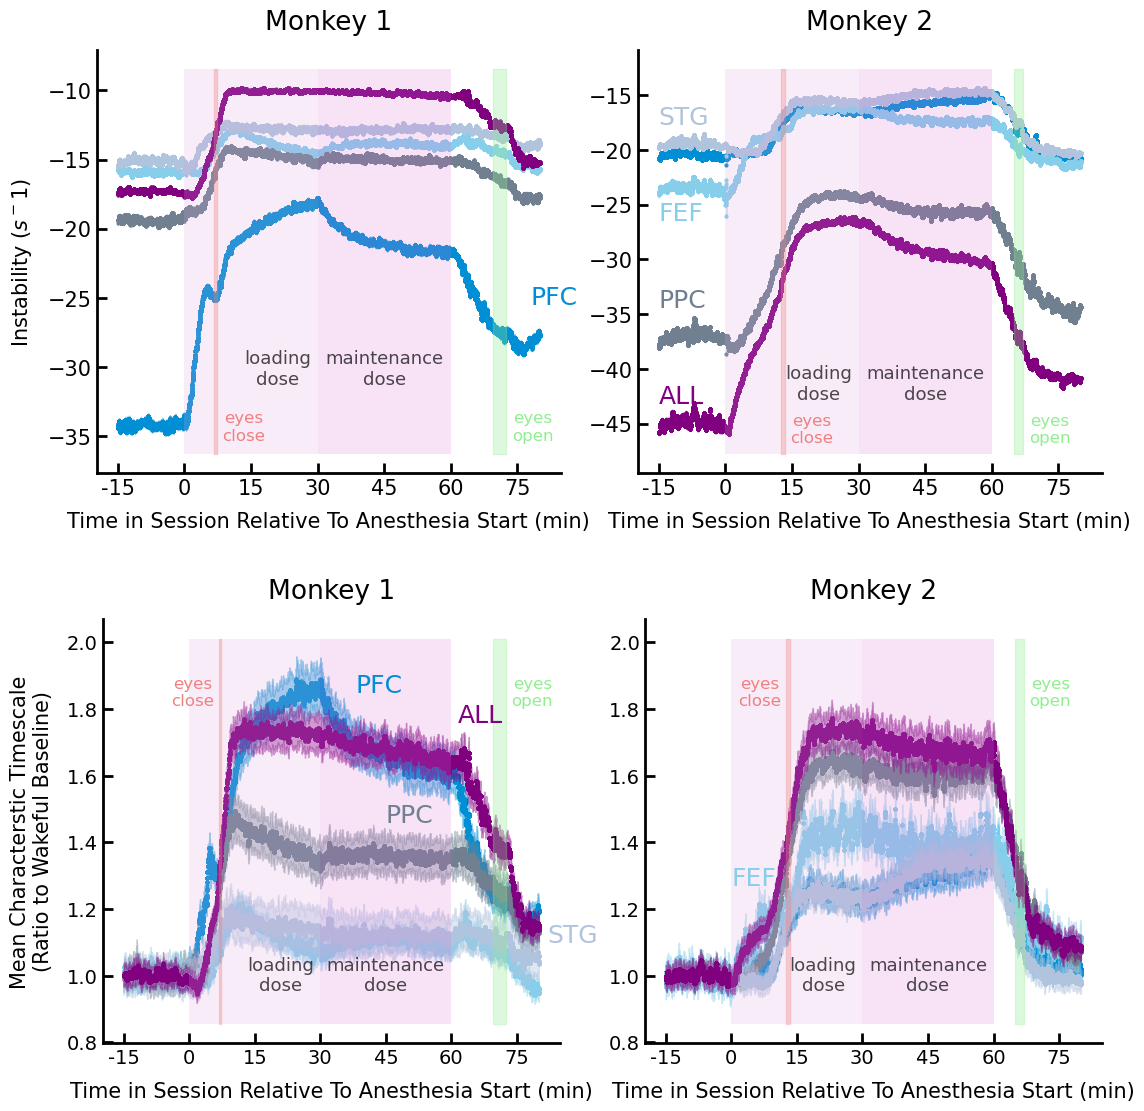

In [130]:
fig = plt.figure(layout='constrained', figsize=(11, 11))
subfigs = fig.subfigures(2, 1, hspace=0.07)

xlabel_fontsize= 15
ylabel_fontsize= 15
tick_fontsize=15
title_fontsize = 19
# legend_fontsize=14
onplot_fontsize=16
area_boost = 2
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 20
s = 4
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

axs = subfigs[0].subplots(1, 2, sharey=False)

lns = []

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    for area in stability_all[monkey].keys():
#     for area in ['vlPFC']:
        
        ax.scatter(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], label=area_labels[area], color=area_colors[area], s=s)
#         ax.errorbar(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], color=area_colors[area], yerr=se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], ls='none', alpha=0.4)
        
#         ax.scatter(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0], label=area_labels[area], color=area_colors[area], s=s)
        lower_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] - se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
        upper_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] + se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
        ax.fill_between(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], lower_bound, upper_bound, alpha=0.4, color=area_colors[area])
        
        if i == 0:
            ln1 = ax.plot([], label=area_labels[area], color=area_colors[area])
            lns += ln1
            
            if area == 'vlPFC':
                ax.text(60 + (plot_end_time - 60)*0.9, mean_stab_all[monkey][area][time_vals >= 60].mean() + 1, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
        if i == 1:
            if area == '7b':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() + 2.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
            if area == 'FEF':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() - 2.85, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
            if area == 'CPB':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() + 1.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
            if area == 'all':
                ax.text(-15, mean_stab_all[monkey][area][time_vals <= 0].mean() + 1.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
# ylim = ax.get_ylim()
for i in range(2):
    ax = axs[i]
    ylim = ax.get_ylim()
    fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, label='infusion 1', edgecolor='none')
    fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, label='infusion 2', edgecolor='none')
    ax.text(21, ylim[0] + 5, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    ax.text(45, ylim[0] + 5, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    if i == 0:
        lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
        lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_ylabel(f'Instability ($s^{-1}$)', fontsize=ylabel_fontsize)
    else:
#         ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='y', which='both', left=True, right=False)
    
    xticks = [-15, 0, 15, 30, 45, 60, 75]
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel('Time in Session Relative To Anesthesia Start (min)', fontsize=xlabel_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_title(f'Monkey {i + 1}', fontsize=title_fontsize)
    
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
    se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
    ax.text((mean_eyes_close + se_eyes_close)/60 + 6, ylim[0] + 1, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
    se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
    ax.text((mean_eyes_open + se_eyes_open)/60 + 6, ylim[0] + 1, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')

# -------------------------------------------
# PLOT 2
# -------------------------------------------
tick_fontsize=14
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 20
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

axs = subfigs[1].subplots(1, 2, sharey=True)

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    for j, area in enumerate(areas):
        ax.scatter(time_vals[time_inds], changes_all[monkey][area][time_inds], label=area_labels[area], color=area_colors[area], s=s)
#         yerr = np.zeros(len(time_inds))
#         yerr[counts_changes_se[monkey][area] > 0] = np.exp(np.log(changes_all[monkey][area][counts_changes_se[monkey][area] > 0]) 
#                                                                                     + np.log(se_changes_all[monkey][area][counts_changes_se[monkey][area] > 0]))
#         ax.errorbar(time_vals[time_inds], changes_all[monkey][area][time_inds], yerr=yerr[time_inds], ls='none', alpha=0.4, color=area_colors[area])
        
        lower_bound = changes_all[monkey][area].copy()
        upper_bound = changes_all[monkey][area].copy()
        lower_bound[counts_changes_se[monkey][area] > 0] = np.exp(np.log(changes_all[monkey][area][counts_changes_se[monkey][area] > 0]) - np.log(se_changes_all[monkey][area][counts_changes_se[monkey][area] > 0]))
        upper_bound[counts_changes_se[monkey][area] > 0] = np.exp(np.log(changes_all[monkey][area][counts_changes_se[monkey][area] > 0]) + np.log(se_changes_all[monkey][area][counts_changes_se[monkey][area] > 0]))
        ax.fill_between(time_vals[time_inds], lower_bound[time_inds], upper_bound[time_inds], alpha=0.4, color=area_colors[area])
       
    #         lower_bound = np.zeros(len(changes_all[monkey][area]))
#         upper_bound = np.zeros(len(changes_all[monkey][area]))
#         lower_bound[counts_changes_se[monkey][area] > 0] = np.exp(np.log(changes_all[monkey][area][counts_changes_se[monkey][area] > 0]) - np.log(se_changes_all[monkey][area][counts_changes_se[monkey][area] > 0]))
#         upper_bound[counts_changes_se[monkey][area] > 0] = np.exp(np.log(changes_all[monkey][area][counts_changes_se[monkey][area] > 0]) + np.log(se_changes_all[monkey][area][counts_changes_se[monkey][area] > 0]))
#         lower_bound[counts_changes_se[monkey][area] > 0] = changes_all[monkey][area][counts_changes_se[monkey][area] > 0] - lower_bound[counts_changes_se[monkey][area] > 0]
#         upper_bound[counts_changes_se[monkey][area] > 0] = upper_bound[counts_changes_se[monkey][area] > 0] - changes_all[monkey][area][counts_changes_se[monkey][area] > 0]
#         asymmetric_error = np.array(list(zip(lower_bound[time_inds], upper_bound[time_inds]))).T
#         ax.errorbar(time_vals[time_inds], changes_all[monkey][area][time_inds], yerr=asymmetric_error, color = area_colors[area], ls='none', alpha=0.4)
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(labelsize=tick_fontsize)
        
        ax.set_title(f'Monkey {i + 1}', fontsize=title_fontsize)
        
        if i == 0:
            if area == 'vlPFC':
                ax.text(38, 1.85, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
            if area == 'CPB':
                ax.text(82, 1.1, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
            if area == 'all':
                ax.text(61.5, 1.76, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
            if area == '7b':
                ax.text(45, 1.46, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
            
        if i == 1:
            if area == 'FEF':
                ax.text(0, 1.27, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize + area_boost)
            
        
ylim = ax.get_ylim()
for i in range(2):
    ax = axs[i]
    fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, label='infusion 1', edgecolor='none')
    fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, label='infusion 2', edgecolor='none')
#     ax.text(24, ylim[0] + 0.05, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
#     ax.text(45, ylim[0] + 0.05, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    if i == 0:
        lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
        lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_ylabel('Mean Characterstic Timescale\n(Ratio to Wakeful Baseline)', ha='center', fontsize=ylabel_fontsize, rotation=90)
#         ax.yaxis.set_label_coords(-0.2,0.44)
    else:
#         ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='y', which='both', left=True, right=False)
    
    xticks = [-15, 0, 15, 30, 45, 60, 75]
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel('Time in Session Relative To Anesthesia Start (min)', fontsize=xlabel_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
#     ax.set_title(f'Monkey {i + 1}', fontsize=title_fontsize)
    
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
    se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
    ax.text(21, ylim[0] + 0.1, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    ax.text(45, ylim[0] + 0.1, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    
    ax.text((mean_eyes_close - se_eyes_close)/60 - 6, ylim[1] - 0.2, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
    #     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
#     ax.text((mean_eyes_close + se_eyes_close)/60 + 4, ylim[0] + 0.01, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
    se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
    ax.text((mean_eyes_open + se_eyes_open)/60 + 6, ylim[1] - 0.2, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
#     ax.text((mean_eyes_open + se_eyes_open)/60 + 4, ylim[0] + 0.01, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    

# Plot 8

In [35]:
top_percent = 0.1

In [36]:
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time

In [37]:
# compute means
# compute standard error

section_info = [('awake', [-15, 0]), ('unconscious', [15, 45]), ('recovery', [75, 85])]

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += len(section_info)*np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)


se_counts_all = {}
mean_stab_all = {}
se_all = {}
mean_freqs_all = {}
se_freqs_all = {}

for monkey in monkeys:
    mean_stab_all[monkey] = {}
    se_all[monkey] = {}
    se_counts_all[monkey] = {}
    mean_freqs_all[monkey] = {}
    se_freqs_all[monkey] = {}
    for area in stability_all[monkey].keys():
        num = int(top_percent*stability_all[monkey][area].shape[1])
        counts_safe = counts[monkey][area][:, :num]
        mean_stab_all[monkey][area] = {}
        mean_freqs_all[monkey][area] = {}
        se_all[monkey][area] = {}
        se_freqs_all[monkey][area] = {}
        se_counts_all[monkey][area] = {}
        for section, bounds in section_info:
            mean_stab_all[monkey][area][section] = stability_all[monkey][area][:, :num].copy()
            mean_freqs_all[monkey][area][section] = freqs_all[monkey][area][:, :num].copy()
            time_inds = np.logical_and(time_vals >= bounds[0], time_vals <= bounds[1])
            mean_stab_all[monkey][area][section] = mean_stab_all[monkey][area][section][time_inds].sum(axis=0)/counts_safe[time_inds].sum(axis=0)
            mean_freqs_all[monkey][area][section] = mean_freqs_all[monkey][area][section][time_inds].sum(axis=0)/counts_safe[time_inds].sum(axis=0)
            se_all[monkey][area][section] = np.zeros(mean_stab_all[monkey][area][section].shape)
            se_freqs_all[monkey][area][section] = np.zeros(mean_freqs_all[monkey][area][section].shape)
            se_counts = np.zeros(mean_stab_all[monkey][area][section].shape)
#              = np.zeros(mean_stab_all[monkey][area].shape)
            for session, session_dict in session_rets.items():
                if len(monkeys) == 1 or monkey in session:
                    filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                    for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                        if (row.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0] and (row.start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1]:
    #                         start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
    #                         end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                            se_all[monkey][area][section][:num] += (row.stability_params[:num] - mean_stab_all[monkey][area][section])**2
                            se_freqs_all[monkey][area][section][:num] += (row.stability_freqs[:num] - mean_freqs_all[monkey][area][section])**2
                            se_counts[:num] += 1

                        iterator.update()
           
            se_all[monkey][area][section] = np.sqrt(se_all[monkey][area][section]/se_counts)/np.sqrt(se_counts)
            se_freqs_all[monkey][area][section] = np.sqrt(se_freqs_all[monkey][area][section]/se_counts)/np.sqrt(se_counts)
            se_counts_all[monkey][area][section] = se_counts
            # se_all[monkey][area][section] = np.sqrt(se_all[monkey][area][section]/se_counts)
iterator.close()

  0%|          | 0/128835 [00:00<?, ?it/s]

In [38]:
monkey = 'Mary'
area = 'vlPFC'
sections = ['awake', 'unconscious', 'recovery']

section_colors = {
    'awake': 'limegreen',
    'unconscious': 'plum',
    'recovery': 'orange'
}

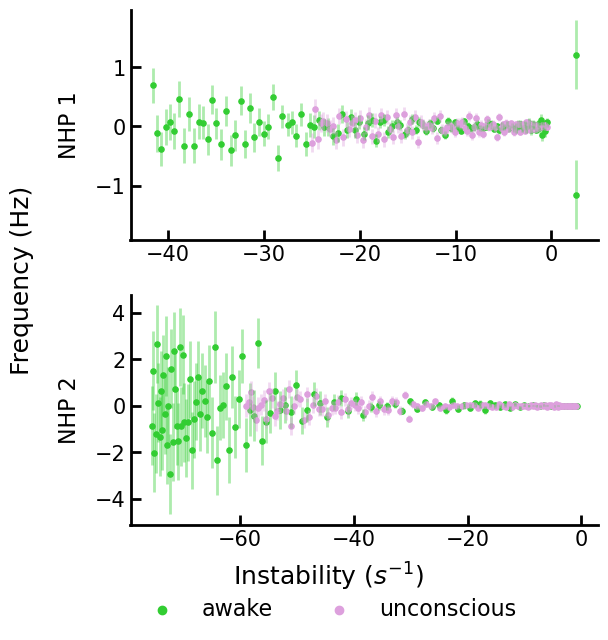

In [39]:
title_fontsize = 18
ylabel_fontsize=18
xlabel_fontsize=18
tick_fontsize=15
legend_fontsize=16
s=14
# fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharey=False, sharex=False)
lns = []
for i, monkey in enumerate(monkeys):
#     for j, area in enumerate(areas):
    for j, area in enumerate(['all']):
        ax = axs[i]
#         for section in sections:
        for section in ['awake', 'unconscious']:
            mean_vals = mean_stab_all[monkey][area][section]
            mean_freqs = mean_freqs_all[monkey][area][section]
            ax.scatter(mean_vals, mean_freqs, c=section_colors[section], label=section, s=s)
            if i == 0 and j == 0:
                scatter = ax.scatter([], [], c=section_colors[section], label=section)
                lns.append(scatter)
#             ax.fill_between(np.arange(len(mean_vals)), mean_vals - se_all[monkey][area][section], mean_vals + se_all[monkey][area][section], color=section_colors[section], alpha=0.4)
            ax.errorbar(mean_vals, mean_freqs, xerr=se_all[monkey][area][section], yerr=se_freqs_all[monkey][area][section], color=section_colors[section], alpha=0.4, linestyle="None")
    
            ax.spines[['right', 'top']].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(labelsize=tick_fontsize)
#             ax.set_xlabel('Characteristic Root #', fontsize=xlabel_fontsize)
            
#             if i == 0:
#                 ax.set_title(area_labels[area], c=area_colors[area], fontsize=title_fontsize)
            if j == 0:
#                 ax.set_ylabel(f'Monkey {i + 1}\nInstability ' + r'($\frac{mV}{s}$)', fontsize=ylabel_fontsize)
                ax.set_ylabel(f'NHP {i + 1}', fontsize=ylabel_fontsize- 2)
            
#             if j == 0:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.yaxis.set_ticks_position('left')
#                 else:
#                     ax.spines[['right', 'top']].set_visible(False)
#                     ax.xaxis.set_ticks_position('bottom')
#                     ax.yaxis.set_ticks_position('left')
#             else:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
#                 else:
#                     ax.spines[['right', 'top', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=True)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
fig.text(0.5, -0.01, 'Instability ' + r'($s^{-1}$)', ha='center', fontsize=xlabel_fontsize)
fig.text(-0.03, 0.5, 'Frequency (Hz)', va='center', rotation='vertical', fontsize=ylabel_fontsize)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3, fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "main", "frequencies.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Plot 9

## Statistical Analysis of Frequencies

In [9]:
# compute means
# compute standard error

section_info = [('awake', [-15, 0]), ('unconscious', [15, 45]), ('recovery', [75, 85])]

top_percent = 0.1

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += len(section_info)*np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)


freqs = {}

for monkey in monkeys:
    freqs[monkey] = {}
    for area in stability_all[monkey].keys():
        num = int(top_percent*stability_all[monkey][area].shape[1])
        freqs[monkey][area] = {}
        for section, bounds in section_info:
            freqs[monkey][area][section] = []
            for session, session_dict in session_rets.items():
                if len(monkeys) == 1 or monkey in session:
                    filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                    for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                        num = int(top_percent*stability_all[monkey][area].shape[1])
                        if (row.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0] and (row.start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1]:
    #                         start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
    #                         end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                            freqs[monkey][area][section].extend(row.stability_freqs[:num])
                            # se_all[monkey][area][section][:num] += (row.stability_params[:num] - mean_stab_all[monkey][area][section])**2
                            # se_freqs_all[monkey][area][section][:num] += (row.stability_freqs[:num] - mean_freqs_all[monkey][area][section])**2
                            # se_counts[:num] += 1

                        iterator.update()
           
            # se_all[monkey][area][section] = np.sqrt(se_all[monkey][area][section]/se_counts)/np.sqrt(se_counts)
            # se_freqs_all[monkey][area][section] = np.sqrt(se_freqs_all[monkey][area][section]/se_counts)/np.sqrt(se_counts)
            # se_counts_all[monkey][area][section] = se_counts
            # se_all[monkey][area][section] = np.sqrt(se_all[monkey][area][section]/se_counts)
iterator.close()

  0%|          | 0/128835 [00:00<?, ?it/s]

### Frequency Analysis

In [10]:
area = 'all'

In [11]:
section_colors = {
    'awake': 'limegreen',
    'unconscious': 'plum',
    'recovery': 'orange'
}

## All Bands

In [23]:
bands = {
    'delta': [0.5, 4],
    'theta': [4, 8],
    'alpha': [8, 12],
    'beta': [12, 30],
    'gamma': [30, 80],
    'high gamma': [80, np.Inf]
}

In [24]:
wake_dists = {}
unconscious_dists = {}
area = 'all'
for monkey in ['Mary', 'MrJones']:
    wake_dists[monkey] = {}
    unconscious_dists[monkey] = {}
    for band, bounds in bands.items():
        min_freq, max_freq = bounds
        awake_inds = np.abs(freqs[monkey][area]['awake'])[(np.abs(freqs[monkey][area]['awake']) >= min_freq) & (np.abs(freqs[monkey][area]['awake']) <= max_freq)]
        unconscious_inds = np.abs(freqs[monkey][area]['unconscious'])[(np.abs(freqs[monkey][area]['unconscious']) >= min_freq) & (np.abs(freqs[monkey][area]['unconscious']) <= max_freq)]
        wake_dists[monkey][band] = len(awake_inds)/len(np.abs(freqs[monkey][area]['awake'])[np.abs(freqs[monkey][area]['awake']) >= 0.5])
        unconscious_dists[monkey][band] = len(unconscious_inds)/len(np.abs(freqs[monkey][area]['unconscious'])[np.abs(freqs[monkey][area]['unconscious']) >= 0.5])
        # print(f"awake percentage = {len(awake_inds)*100/len(freqs[monkey][area]['awake']):.3f}")
        # print(f"unconscious percentage = {len(unconscious_inds)*100/len(freqs[monkey][area]['unconscious']):.5f}")
        
      

In [25]:
def statistic(a, b, band, bands=bands):
    min_freq, max_freq = bands[band]
    pa = len(a[(a >= min_freq) & (a < max_freq)])/len(a)
    pb = len(b[(b >= min_freq) & (b < max_freq)])/len(b)
    return pb - pa

In [28]:
monkey = 'Mary'
data = [np.abs(freqs[monkey][area]['awake'])[np.abs(freqs[monkey][area]['awake']) >= 0.5], np.abs(freqs[monkey][area]['unconscious'])[np.abs(freqs[monkey][area]['unconscious']) >= 0.5]]

In [36]:
res = scipy.stats.permutation_test(data, lambda a, b: statistic(a, b, band='theta'), n_resamples=1000)
res.pvalue, res.statistic

(0.001998001998001998, 0.06026983917679116)

In [37]:
res = scipy.stats.permutation_test(data, lambda a, b: statistic(a, b, band='beta'), n_resamples=1000)
res.pvalue, res.statistic

(0.03396603396603397, 0.0044798551044387125)

In [39]:
monkey = 'MrJones'
data = [np.abs(freqs[monkey][area]['awake'])[np.abs(freqs[monkey][area]['awake']) >= 0.5], np.abs(freqs[monkey][area]['unconscious'])[np.abs(freqs[monkey][area]['unconscious']) >= 0.5]]

In [40]:
res = scipy.stats.permutation_test(data, lambda a, b: statistic(a, b, band='delta'), n_resamples=1000)
res.pvalue, res.statistic

(0.001998001998001998, 0.2945863639837091)

In [41]:
res = scipy.stats.permutation_test(data, lambda a, b: statistic(a, b, band='gamma'), n_resamples=1000)
res.pvalue, res.statistic

(0.001998001998001998, -0.35513257184408)

In [44]:
from matplotlib.patches import Rectangle

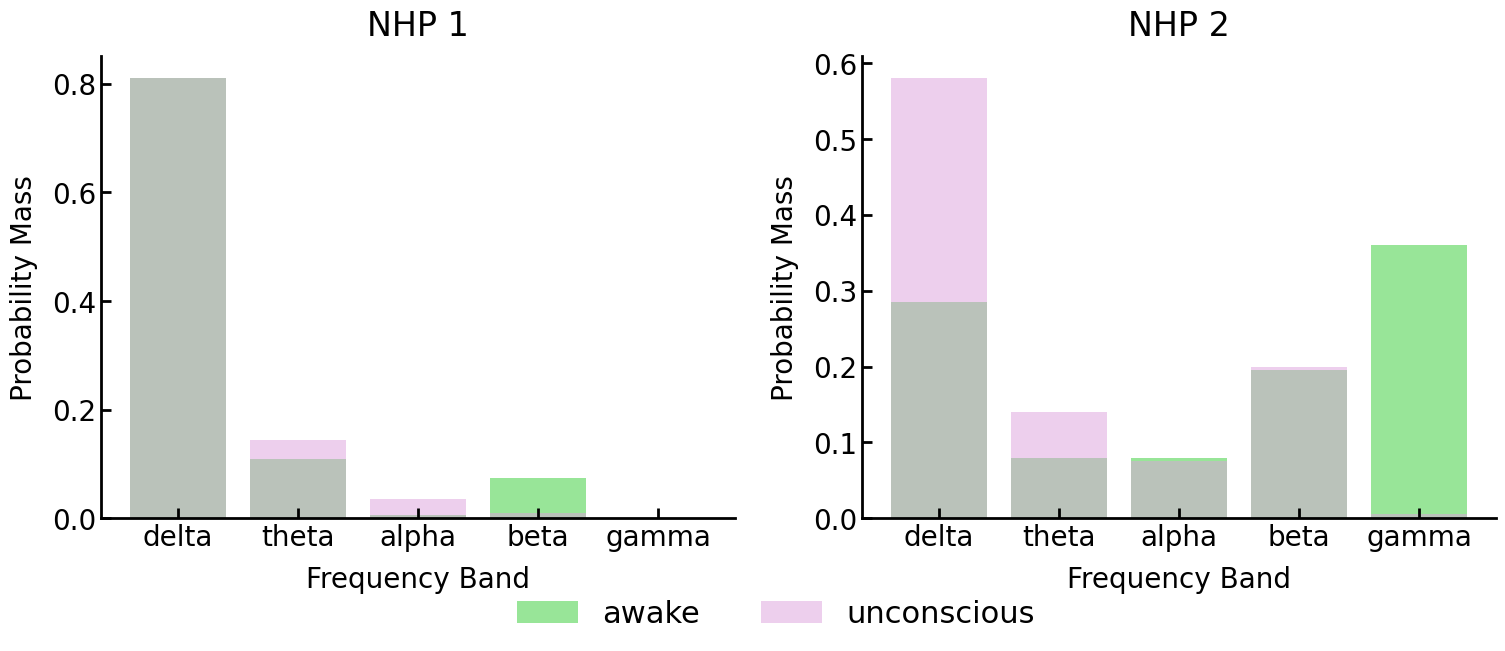

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
ax = axs[0]
monkey = 'Mary'
ax.bar([band for band in wake_dists[monkey].keys() if band != 'high gamma'], [wake_dists[monkey][band] for band in wake_dists[monkey].keys() if band != 'high gamma'], color=section_colors['awake'], alpha=0.5)
ax.bar([band for band in wake_dists[monkey].keys() if band != 'high gamma'], [unconscious_dists[monkey][band] for band in wake_dists[monkey].keys() if band != 'high gamma'], color=section_colors['unconscious'], alpha=0.5)
# ax.set_yscale('log')
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title('NHP 1')
ax.set_ylabel('Probability Mass')
ax.set_xlabel('Frequency Band')

ax = axs[1]
monkey = 'MrJones'
ax.bar([band for band in wake_dists[monkey].keys() if band != 'high gamma'], [wake_dists[monkey][band] for band in wake_dists[monkey].keys() if band != 'high gamma'], color=section_colors['awake'], alpha=0.5)
ax.bar([band for band in wake_dists[monkey].keys() if band != 'high gamma'], [unconscious_dists[monkey][band] for band in wake_dists[monkey].keys() if band != 'high gamma'], color=section_colors['unconscious'], alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title('NHP 2')
ax.set_ylabel('Probability Mass')
ax.set_xlabel('Frequency Band')

legend_fontsize=22
handles = [Rectangle((0,0),1,1,color=section_colors[section],alpha=0.5, ec='none') for section in ['awake', 'unconscious']]
labels= ['awake', 'unconscious']
fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3, fontsize=legend_fontsize)


plt.show()